# eQTL Methods Exploration

I want to look at a few things here:

* make sure EMMAX is actually using the covariates I'm providing
* the effect of using different expression estimates
* the effect of quantile normalization followed by transformation to a standard normal
* the effect of including (genotype or expression) PCs as covariates?

It's not clear to me how I can compare different approaches to see which is "best." 
One approach could be to use the GTEx multi-tissue eQTLs as a gold standard. If some
particular approach ascribes more significance to the GTEx multi-tissue eQTLs than
other approaches, that approach could be considered superior. However, that approach
may also lead to more false posititives.

In [1]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import sys

import cdpybio as cpb
import matplotlib.pyplot as plt
import mygene
import myvariant
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'eqtl_methods_exploration'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
exp = pd.read_table(os.path.join(
        ciepy.root, 'output', 'eqtl_input', 
        'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), 
                    index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'gene_to_regions.p')
gene_to_regions = cPickle.load(open(fn, 'rb'))
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

# This file has the probability of the SNP being a QTL for each tissue
# for the top SNP for that gene. 
fn = ('/publicdata/gtex_multi_tissue_20151212/'
      'Multi_tissue_eQTL_GTEx_Pilot_Phase_datasets/'
      'res_final_amean_com_genes_com_snps.txt')
multi_probs = pd.read_table(fn, index_col=0)

In [5]:
def orig_dir():
    os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks/')

I've copied the methods from the `run_emmax.py` script here so I can run some
simple analyses.

This is an example call to `run_emmax.py`:

    python /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/scripts/run_emmax.py \
        ENSG00000103723.8 \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_data/wgs/biallelic_snvs.vcf.gz \
        chr15:82331447-84378665 \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/vst_counts_phe.tsv \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax.ind \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/wgs.kin \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/run_eqtl_analysis/test_results/ENSG00000103723.8 \
        -c /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax.cov
        
The genes ENSG00000189306.6 and ENSG00000169715.10 are significant while ENSG00000181315.6
and ENSG00000198912.6 are not significant. I can use these for testing.

## Gold Standard

To evaluate methodologies, I'm going to compare the $p$-values for a set of high-confidence
multi-tissue eQTLs (defined as GTEx eQTLs that have probability of 1 for being an eQTL
in each tissue in the multi-tissue analysis). First I need to figure out the coordinates of
the dbSNP IDs GTEx used since I'm using a different dbSNP version.

In [6]:
# Remove insertions/deletions.
multi_probs = multi_probs[multi_probs.snp.apply(lambda x: x[0:2] == 'rs')]
multi_probs_sum = multi_probs.sum(axis=1)
multi_probs_sum.sort_values(ascending=False, inplace=True)
top_eqtls = multi_probs_sum[multi_probs_sum == 9]
#intersection = set(vsd_phe.index) & set(evsd_phe.index) & set(tpm_phe.index)
#top_eqtls = top_eqtls.ix[set(top_eqtls.index) & intersection]
top_eqtls = top_eqtls.ix[set(top_eqtls.index) & set(exp.index)]
top_eqtls.shape

(64,)

There are 64 "top" eQTLs. It seems like MyVariantInfo doesn't have information
on all of them, so I'll just keep those I can get position information for.

In [7]:
mg = mygene.MyGeneInfo()
mv = myvariant.MyVariantInfo()
rsids = []
chroms = []
starts = []
gtex_genes = []
my_genes = []
for gene_id in top_eqtls.index:
    my_gene_id = None
    if gene_id in gene_info.index:
        my_gene_id = gene_id
    else:
        try:
            res = mg.getgene(gene_id.split('.')[0])
            symbol = res['symbol']
            my_gene_id = gene_info[gene_info.gene_name == symbol].index[0]
        except AssertionError:
            break
    if my_gene_id:
        rsid = multi_probs.ix[gene_id, 'snp']
        res = mv.query('dbsnp.rsid:{}'.format(rsid), fields='dbsnp')
        if len(res['hits']) == 1:
            rsids.append(rsid)
            chroms.append(res['hits'][0]['dbsnp']['chrom'])
            starts.append(res['hits'][0]['dbsnp']['hg19']['start'])
            gtex_genes.append(gene_id)
            my_genes.append(my_gene_id)
            
gold_eqtls = pd.DataFrame([chroms, starts, gtex_genes, my_genes, rsids], columns=my_genes,
                          index=['chrom', 'start', 'gtex_gene_id', 'my_gene_id', 'rsid']).T
gold_eqtls['snp'] = 'chr' + gold_eqtls.chrom.astype(str) + ':' + gold_eqtls.start.astype(str)
gold_eqtls.to_csv(os.path.join(outdir, 'gold_eqtls.tsv'), 
                  sep='\t')

In [ ]:
2 + 

## Is EMMAX using covariates?

I just want to do a sanity check to make sure EMMAX makes different covariate files
when I provide different covariate information.

In [30]:
gene_id = gold_eqtls.index[0]
all_vcf = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                       'filtered_all', '0000.vcf.gz')
#all_vcf = ('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/'
#           'private_data/wgs/biallelic_snvs.vcf.gz')
ind = '/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax.ind'
phenotypes = '/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/vst_counts_phe.tsv'
kin = '/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/wgs.kin'
cov = '/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax.cov'

In [31]:
os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks/')

tempdir = os.path.join('/dev/shm', gene_id)
cpy.makedir(tempdir)

curdir = os.path.realpath(os.curdir)
os.chdir(tempdir)

# Make VCF file. This VCF file will only have biallelic SNVs in the regions
# of interest.
regions = gene_to_regions[gene_id]
vcf = _make_emmax_vcf(all_vcf, gene_id, tempdir, regions, ind)

# Make phe file.
order = pd.read_table(ind, index_col=0, header=None)
phenos = pd.read_table(phenotypes, index_col=0)[order.index]
phenof = os.path.join(tempdir, '{}.phe'.format(gene_id))
_phe(phenof, gene_id, phenos)

# Make reml file.
eigf = os.path.join(tempdir, '{}.eigR'.format(gene_id))
remlf = os.path.join(tempdir, '{}.reml'.format(gene_id))
_reml(eigf, remlf, phenof, ind, kin, cov=cov)

# Run association.
out = os.path.join(tempdir, '{}.tsv'.format(gene_id))
_emmax(out, vcf, phenof, ind, eigf, remlf)
#_emmax_cleanup(gene_id)
real_res = pd.read_table(out)
min_pval = real_res.PVALUE.min()

# Make reml file with no covariates.
eigf_no_cov = os.path.join(tempdir, '{}_no_cov.eigR'.format(gene_id))
remlf_no_cov = os.path.join(tempdir, '{}_no_cov.reml'.format(gene_id))
_reml(eigf_no_cov, remlf_no_cov, phenof, ind, kin)

print(os.path.getsize(eigf))
print(os.path.getsize(eigf_no_cov))

307312
312016


So the eigenvector file is different when I don't include covariates.

In [32]:
c = pd.read_table(cov, header=None, index_col=0)

# Make covariate file with only sex information.
sex_only_cov = os.path.join(tempdir, 'sex_only.cov')
c[1].to_csv(sex_only_cov, header=None, sep='\t')

# Make reml file with only sex covariate.
eigf_sex_only = os.path.join(tempdir, '{}_sex_only.eigR'.format(gene_id))
remlf_sex_only = os.path.join(tempdir, '{}_sex_only.reml'.format(gene_id))
_reml(eigf_sex_only, remlf_sex_only, phenof, ind, kin, cov=sex_only_cov)

print(os.path.getsize(eigf))
print(os.path.getsize(eigf_sex_only))

307312
310448


The eigenvector file is also different when I remove the batch covariates. 
So it appears that EMMAX is doing *something* different when I give it covariates.

## Different Expression Estimates

I'm considering using three different expression estimates:
* naive counts: The number of reads overlapping a gene.
* RSEM effective counts: The effective counts estimated by RSEM.
* RSEM TPM: Transcript TPM summed together per gene.

I want to make a method that takes as input each and outputs the 
correlation between expected counts/TPM and naive counts
as well as the $p$-value correlation.

In [38]:
# Run association.
out = os.path.join(tempdir, '{}_evsd.tsv'.format(gene_id))
_emmax(out, vcf, evsd_phenof, ind, eigf, remlf)
#_emmax_cleanup(gene_id)
evsd_res = pd.read_table(out)
out = os.path.join(tempdir, '{}_tpm.tsv'.format(gene_id))
_emmax(out, vcf, tpm_phenof, ind, eigf, remlf)
#_emmax_cleanup(gene_id)
tpm_res = pd.read_table(out)

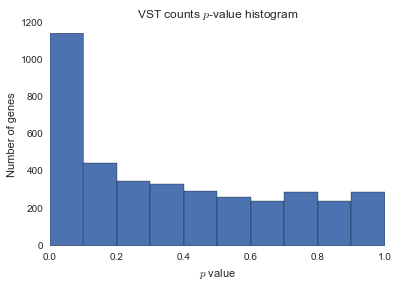

In [39]:
real_res.PVALUE.hist()
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('VST counts $p$-value histogram');

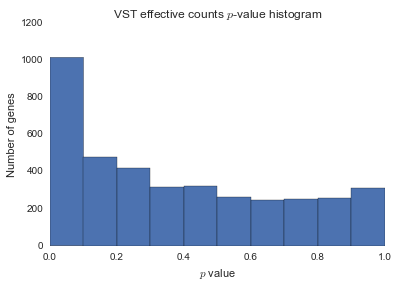

In [40]:
evsd_res.PVALUE.hist()
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('VST effective counts $p$-value histogram');

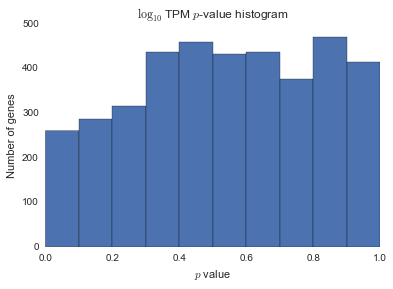

In [41]:
tpm_res.PVALUE.hist()
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('$\log_{10}$ TPM $p$-value histogram');

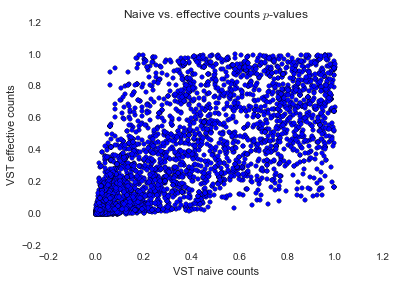

In [42]:
plt.scatter(real_res.PVALUE, evsd_res.PVALUE)
plt.ylabel('VST effective counts')
plt.xlabel('VST naive counts')
plt.title('Naive vs. effective counts $p$-values');

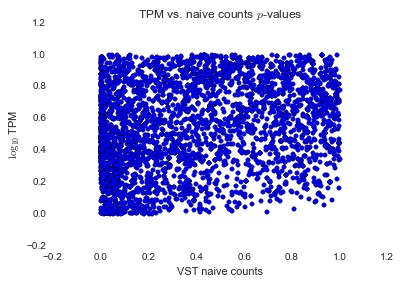

In [43]:
plt.scatter(real_res.PVALUE, tpm_res.PVALUE)
plt.ylabel('$\log_{10}$ TPM')
plt.xlabel('VST naive counts')
plt.title('TPM vs. naive counts $p$-values');

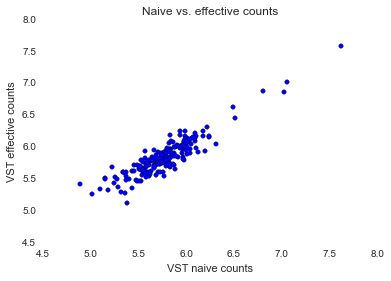

In [44]:
plt.scatter(vsd_phe.ix[gene_id], evsd_phe.ix[gene_id])
plt.ylabel('VST effective counts')
plt.xlabel('VST naive counts')
plt.title('Naive vs. effective counts');

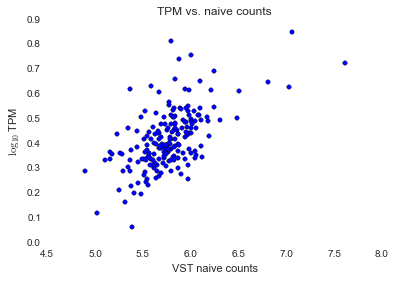

In [45]:
plt.scatter(vsd_phe.ix[gene_id], tpm_phe.ix[gene_id])
plt.ylabel('$\log_{10}$ TPM')
plt.xlabel('VST naive counts')
plt.title('TPM vs. naive counts');

Just looking at one gene, we can see that there is little difference between
using naive counts and RSEM effective counts. I imagine there are some genes 
that differ more using these two estimates, but my experience has been that
the effective counts are very similar to the naive counts.

The $p$-values for TPM are quite different than those for the naive counts. 
The expression estimates themselves are correlated. I think that this difference
may arise in part because TPM is limited in scale. It may also be the case that
the $\log$ transformation doesn't make the TPM values very "normal" compared to
the VST naive counts.

In [144]:
def compare_exp_estimates(gene_id):
    tempdir = os.path.join('/dev/shm', gene_id)
    cpy.makedir(tempdir)

    curdir = os.path.realpath(os.curdir)
    os.chdir(tempdir)

    # Make VCF file. This VCF file will only have biallelic SNVs in the regions
    # of interest.
    regions = gene_to_regions[gene_id]
    vcf = _make_emmax_vcf(all_vcf, gene_id, tempdir, regions, ind)

    # Make phe files.
    order = pd.read_table(ind, index_col=0, header=None)
    phenos = pd.read_table(phenotypes, index_col=0)[order.index]
    phenof = os.path.join(tempdir, '{}.phe'.format(gene_id))
    _phe(phenof, gene_id, vsd_phe)
    evsd_phenof = os.path.join(tempdir, '{}_evsd.phe'.format(gene_id))
    _phe(evsd_phenof, gene_id, evsd_phe)
    tpm_phenof = os.path.join(tempdir, '{}_tpm.phe'.format(gene_id))
    _phe(tpm_phenof, gene_id, tpm_phe)
    fpkm_phenof = os.path.join(tempdir, '{}_fpkm.phe'.format(gene_id))
    _phe(fpkm_phenof, gene_id, fpkm_phe)
    
    phenof_std_norm = os.path.join(tempdir, '{}_std_norm.phe'.format(gene_id))
    _phe(phenof_std_norm, gene_id, vsd_phe_std_norm)
    evsd_phenof_std_norm = os.path.join(tempdir, '{}_evsd_std_norm.phe'.format(gene_id))
    _phe(evsd_phenof_std_norm, gene_id, evsd_phe_std_norm)
    tpm_phenof_std_norm = os.path.join(tempdir, '{}_tpm_std_norm.phe'.format(gene_id))
    _phe(tpm_phenof_std_norm, gene_id, tpm_phe_std_norm)
    fpkm_phenof_std_norm = os.path.join(tempdir, '{}_fpkm_std_norm.phe'.format(gene_id))
    _phe(fpkm_phenof_std_norm, gene_id, fpkm_phe_std_norm)

    # Make reml file.
    eigf = os.path.join(tempdir, '{}.eigR'.format(gene_id))
    remlf = os.path.join(tempdir, '{}.reml'.format(gene_id))
    _reml(eigf, remlf, phenof, ind, kin, cov=cov)

    # Run associations.
    out = os.path.join(tempdir, '{}.tsv'.format(gene_id))
    _emmax(out, vcf, phenof, ind, eigf, remlf)
    vsd_res = pd.read_table(out)
    out = os.path.join(tempdir, '{}_evsd.tsv'.format(gene_id))
    _emmax(out, vcf, evsd_phenof, ind, eigf, remlf)
    evsd_res = pd.read_table(out)
    out = os.path.join(tempdir, '{}_tpm.tsv'.format(gene_id))
    _emmax(out, vcf, tpm_phenof, ind, eigf, remlf)
    tpm_res = pd.read_table(out)
    out = os.path.join(tempdir, '{}_fpkm.tsv'.format(gene_id))
    _emmax(out, vcf, fpkm_phenof, ind, eigf, remlf)
    fpkm_res = pd.read_table(out)
    
    out = os.path.join(tempdir, '{}_std_norm.tsv'.format(gene_id))
    _emmax(out, vcf, phenof_std_norm, ind, eigf, remlf)
    vsd_res_std_norm = pd.read_table(out)
    out = os.path.join(tempdir, '{}_evsd_std_norm.tsv'.format(gene_id))
    _emmax(out, vcf, evsd_phenof_std_norm, ind, eigf, remlf)
    evsd_res_std_norm = pd.read_table(out)
    out = os.path.join(tempdir, '{}_tpm_std_norm.tsv'.format(gene_id))
    _emmax(out, vcf, tpm_phenof_std_norm, ind, eigf, remlf)
    tpm_res_std_norm = pd.read_table(out)
    out = os.path.join(tempdir, '{}_fpkm_std_norm.tsv'.format(gene_id))
    _emmax(out, vcf, fpkm_phenof_std_norm, ind, eigf, remlf)
    fpkm_res_std_norm = pd.read_table(out)
    
    pvals = pd.DataFrame({'vsd_pval':vsd_res.PVALUE.values,
                          'evsd_pval':evsd_res.PVALUE.values,
                          'tpm_pval':tpm_res.PVALUE.values,
                          'fpkm_pval':fpkm_res.PVALUE.values,
                          'vsd_pval_std_norm':vsd_res_std_norm.PVALUE.values,
                          'evsd_pval_std_norm':evsd_res_std_norm.PVALUE.values,
                          'tpm_pval_std_norm':tpm_res_std_norm.PVALUE.values,
                          'fpkm_pval_std_norm':fpkm_res_std_norm.PVALUE.values
                         },
                         index=('chr' + vsd_res['#CHROM'].astype(str) + 
                                ':' + vsd_res.BEG.astype(str)))
                          
    exp = pd.DataFrame({'vsd_exp':vsd_phe.ix[gene_id],
                        'evsd_exp':evsd_phe.ix[gene_id], 
                        'tpm_exp':tpm_phe.ix[gene_id].values,
                        'fpkm_exp':fpkm_phe.ix[gene_id].values,
                        'vsd_exp_std_norm':vsd_phe_std_norm.ix[gene_id],
                        'evsd_exp_std_norm':evsd_phe_std_norm.ix[gene_id], 
                        'tpm_exp_std_norm':tpm_phe_std_norm.ix[gene_id].values,
                        'fpkm_exp_std_norm':fpkm_phe_std_norm.ix[gene_id].values})
    
    shutil.rmtree(tempdir)
    orig_dir()
    return pvals, exp

In [148]:
pvals = {}
exp = {}
gold_genes = []
gold_pvals = []
for g in gold_eqtls.my_gene_id:
    p, e = compare_exp_estimates(g)
    pvals[g] = p
    exp[g] = e
    if gold_eqtls.ix[g, 'snp'] in p.index:
        gold_genes.append(g)
        gold_pvals.append(p.ix[gold_eqtls.ix[g, 'snp']])
gold_pvals = pd.DataFrame(gold_pvals, index=gold_genes)
log_gold_pvals = -np.log10(gold_pvals)

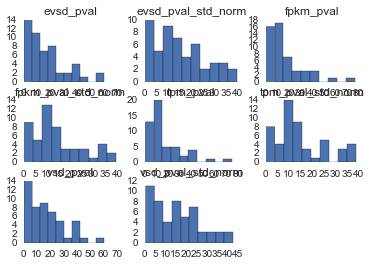

In [158]:
a = log_gold_pvals.hist()

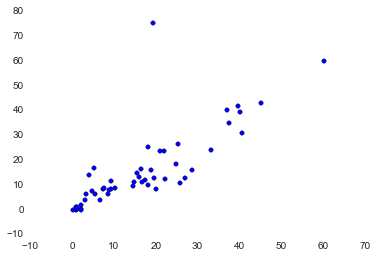

In [163]:
plt.scatter(log_gold_pvals.vsd_pval, log_gold_pvals.tpm_pval)

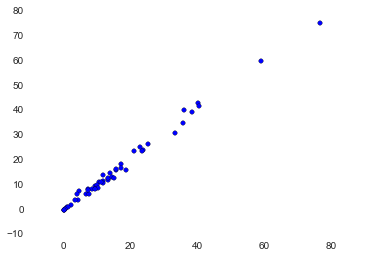

In [162]:
plt.scatter(log_gold_pvals.fpkm_pval, log_gold_pvals.tpm_pval)

In [153]:
log_gold_pvals.sum()

evsd_pval             861.924527
evsd_pval_std_norm    758.585425
fpkm_pval             807.900396
fpkm_pval_std_norm    704.805923
tpm_pval              823.959170
tpm_pval_std_norm     722.797981
vsd_pval              861.358998
vsd_pval_std_norm     774.362060
dtype: float64

In [165]:
log_gold_pvals.corr()

,evsd_pval,evsd_pval_std_norm,fpkm_pval,fpkm_pval_std_norm,tpm_pval,tpm_pval_std_norm,vsd_pval,vsd_pval_std_norm
evsd_pval,1.000000,0.964929,0.963991,0.953094,0.957743,0.939168,0.895202,0.873549
evsd_pval_std_norm,0.964929,1.000000,0.904671,0.971543,0.898728,0.956456,0.904722,0.936513
fpkm_pval,0.963991,0.904671,1.000000,0.943567,0.995838,0.933551,0.788346,0.762051
fpkm_pval_std_norm,0.953094,0.971543,0.943567,1.000000,0.944875,0.993991,0.866676,0.885776
tpm_pval,0.957743,0.898728,0.995838,0.944875,1.000000,0.944307,0.787027,0.758746
tpm_pval_std_norm,0.939168,0.956456,0.933551,0.993991,0.944307,1.000000,0.859680,0.875380
vsd_pval,0.895202,0.904722,0.788346,0.866676,0.787027,0.859680,1.000000,0.972497
vsd_pval_std_norm,0.873549,0.936513,0.762051,0.885776,0.758746,0.875380,0.972497,1.000000


In [199]:
def run_emmax_comparison(gene_id):
    phes = ['vst_counts_phe.tsv',
            'vst_expected_counts_phe.tsv',
            'tpm_log_filtered_phe.tsv',
            'fpkm_log_filtered_phe.tsv',
            'vst_counts_phe_std_norm.tsv',
            'vst_expected_counts_phe_std_norm.tsv',
            'tpm_log_filtered_phe_std_norm.tsv',
            'fpkm_log_filtered_phe_std_norm.tsv']
    phes = [os.path.join(ciepy.root, 'output', 'eqtl_input', x) for x in phes]
    for phe in phes:
        run_emmax(gene_id, phe)

In [177]:
def run_emmax(gene_id, phe):
    os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks')
    name = os.path.split(phe)[1].split('.')[0]
    toutdir = os.path.join(outdir, name, gene_id)
    if not os.path.exists(toutdir):
        cpy.makedir(toutdir)
        fn = os.path.join(toutdir, '{}.sh'.format(gene_id))
        with open(fn, 'w') as f:
            c = 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
            c += ' \\\n\t'.join([
                    gene_id,
                    os.path.join(ciepy.root, 'private_data', 'wgs', 'biallelic_snvs.vcf.gz'),
                    ','.join(gene_to_regions[gene_id]),
                    phe,
                    os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax.ind'),
                    os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin'),
                    toutdir,
                    '-c {}'.format(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                                'emmax.cov')),
                ])
            f.write(c + '\n')
        subprocess.check_call('bash {}'.format(fn), shell=True)

In [200]:
!ipcluster stop --profile=cardips

2015-09-07 18:46:16.679 [IPClusterStop] Stopping cluster [pid=46196] with [signal=2]


In [201]:
!ipcluster start -n 15 --daemon --profile=cardips
!sleep 60

In [202]:
from IPython.parallel import Client
parallel_client = Client()

In [203]:
dview = parallel_client[:]
with dview.sync_imports():
    import os
    import subprocess
    import time
    import cardipspy
    import ciepy

importing os on engine(s)
importing subprocess on engine(s)
importing time on engine(s)
importing cardipspy on engine(s)
importing ciepy on engine(s)


In [204]:
%px cpy = cardipspy

In [205]:
todo = list(gold_eqtls.index)

In [206]:
dview.push(dict(gene_to_regions=gene_to_regions, outdir=outdir, run_emmax=run_emmax,
                run_emmax_comparison=run_emmax_comparison))
dview.scatter('todo', todo);

<AsyncResult: scatter>

In [ ]:
sleep = np.arange(0, 10 * len(parallel_client.ids), 10)
dview.scatter('sleep', sleep);

In [ ]:
%px time.sleep(sleep[0]) ; [run_emmax_comparison(x) for x in todo]